In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Thu Jan 18 02:11:20 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   39C    P0    65W / 300W |   8351MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bmin_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.z_activation = F.tanh
hp.activation = F.sigmoid

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-10/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

total 306384
-rw-rw-r-- 1 scpark scpark  4198260  1월 18 02:11 events.out.tfevents.1705499748.GPUSVR11
-rw-rw-r-- 1 scpark scpark 44181405  1월 18 02:10 save_43115
-rw-rw-r-- 1 scpark scpark 44181405  1월 18 01:56 save_40000
-rw-rw-r-- 1 scpark scpark 44181405  1월 18 01:11 save_30000
-rw-rw-r-- 1 scpark scpark 44181405  1월 18 00:26 save_20000
-rw-rw-r-- 1 scpark scpark 44181405  1월 17 23:41 save_10000
-rw-rw-r-- 1 scpark scpark 44175485  1월 17 22:56 save_0
-rw-rw-r-- 1 scpark scpark   206852  1월 17 22:55 events.out.tfevents.1705499121.GPUSVR11
-rw-rw-r-- 1 scpark scpark 44180973  1월 17 22:50 save_950
-rw-rw-r-- 1 scpark scpark       40  1월 17 22:45 events.out.tfevents.1705498978.GPUSVR11
-rw-rw-r-- 1 scpark scpark    29636  1월 17 22:45 events.out.tfevents.1705498981.GPUSVR11
-rw-rw-r-- 1 scpark scpark       40  1월 17 18:02 events.out.tfevents.1705482072.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

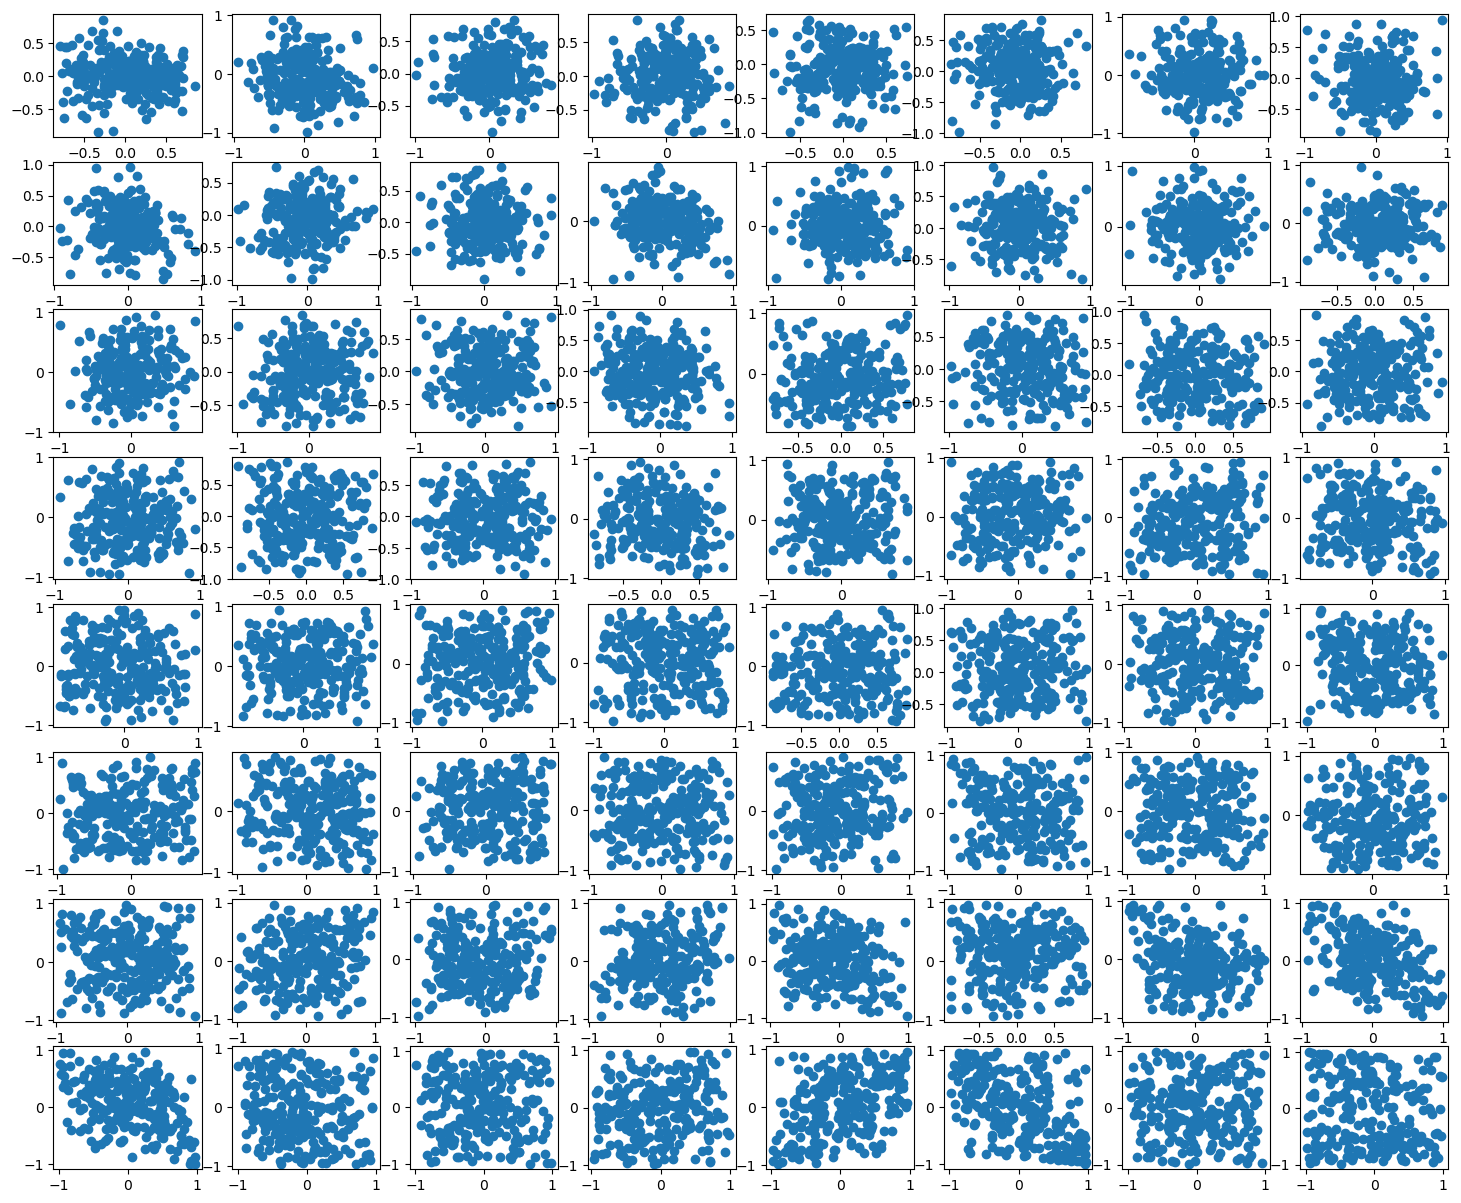

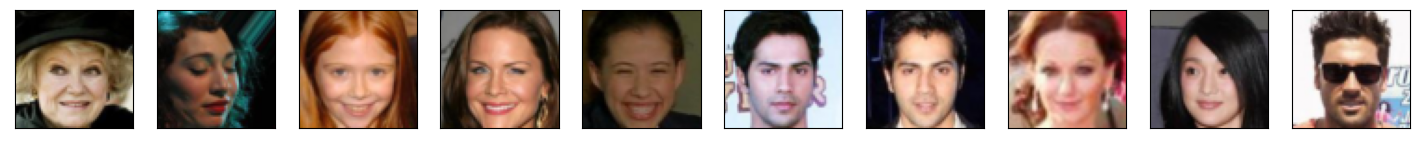

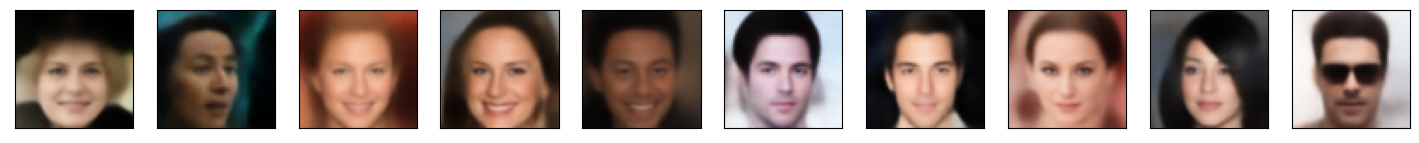

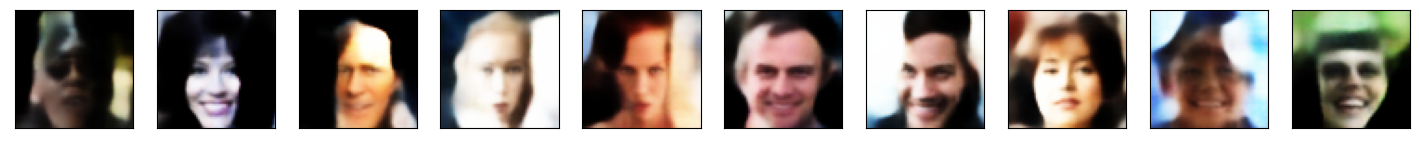

84001
lse_loss 0.0004006193135865033
recon_loss 0.008665057457983493


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



90741
lse_loss 0.0004143850936088711
recon_loss 0.008995772153139115
90742
lse_loss 0.00041680326394271104
recon_loss 0.00897391801699996
90743
lse_loss 0.0004851573234191164
recon_loss 0.008624211233109236
90744
lse_loss 0.000536027824273333
recon_loss 0.008170049544423819
90745
lse_loss 0.0004721301898825914
recon_loss 0.008262433111667633
90746
lse_loss 0.0004653018550015986
recon_loss 0.00840999512001872
90747
lse_loss 0.0004679189994931221
recon_loss 0.007823212211951614
90748
lse_loss 0.0004604827030561864
recon_loss 0.009223105665296317
90749
lse_loss 0.0004329916060669348
recon_loss 0.008237115666270256
90750
lse_loss 0.0005068224418209866
recon_loss 0.00843657562509179
90751
lse_loss 0.0004349921946413815
recon_loss 0.008618409745395184
90752
lse_loss 0.000397982686990872
recon_loss 0.009036238305270672
90753
lse_loss 0.00047011617280077187
recon_loss 0.00903475433588028
90754
lse_loss 0.0004387227440020069
recon_loss 0.008595232293009758
90755
lse_loss 0.0004584811744280159
r

90860
lse_loss 0.0003607515594922006
recon_loss 0.008813180215656757
90861
lse_loss 0.00043016791460104287
recon_loss 0.008721197210252284
90862
lse_loss 0.0004059313854668289
recon_loss 0.008307286817580462
90863
lse_loss 0.00043531461269594727
recon_loss 0.008263370767235757
90864
lse_loss 0.00048040881229098885
recon_loss 0.008564272243529559
90865
lse_loss 0.0004204278258839622
recon_loss 0.008984772954136133
90866
lse_loss 0.00044573344639502465
recon_loss 0.009041314385831356
90867
lse_loss 0.00044846641249023377
recon_loss 0.008717511780560017
90868
lse_loss 0.000418255158001557
recon_loss 0.008862682152539492
90869
lse_loss 0.000518731668125838
recon_loss 0.008735846914350986
90870
lse_loss 0.00046606494579464196
recon_loss 0.008304166374728084
90871
lse_loss 0.000516986459842883
recon_loss 0.009258473478257655
90872
lse_loss 0.0004141981364227831
recon_loss 0.009175923001021147
90873
lse_loss 0.000427620968548581
recon_loss 0.009092892706394195
90874
lse_loss 0.000449402545928

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 0.1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            z = data['z_copy'].data.cpu().numpy()
            plt.figure(figsize=[18, 15])
            for i in range(64):
                plt.subplot(8, 8, i+1)
                plt.scatter(z[:, 2*i], z[:, 2*i+1])
            plt.show()
        
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [13]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


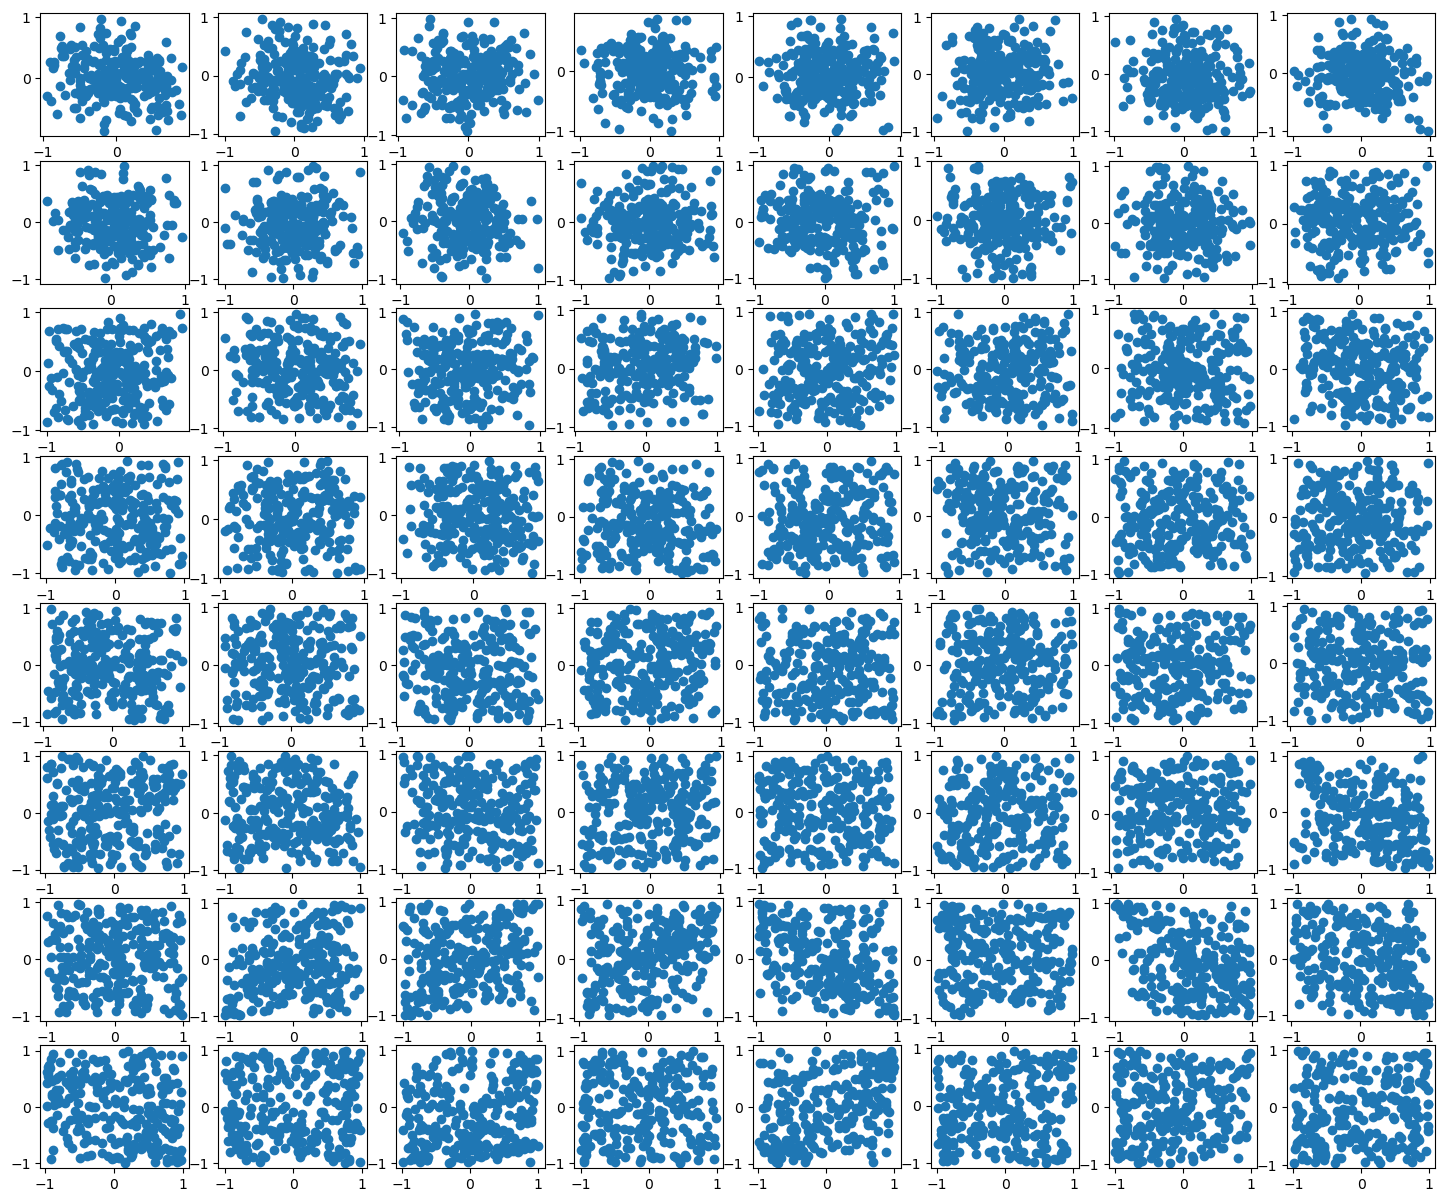

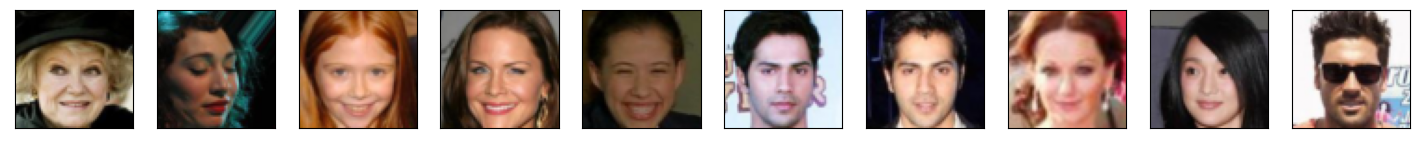

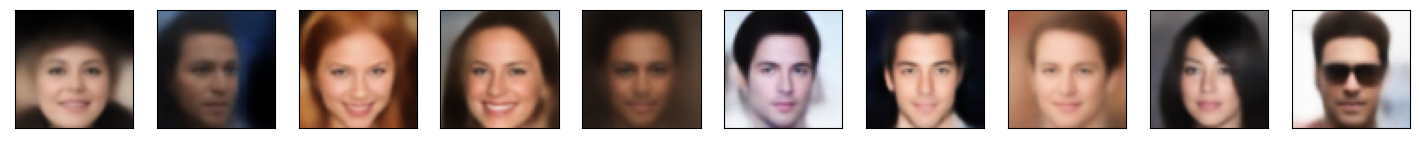

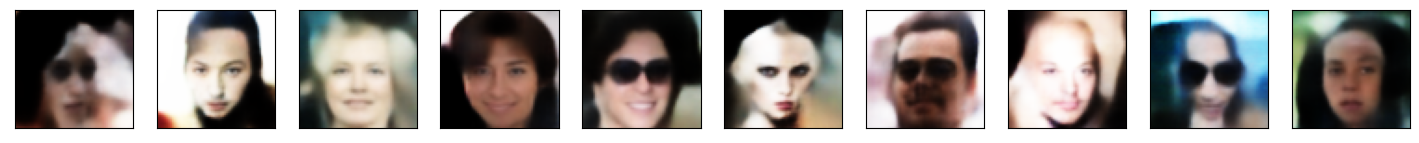

In [14]:
import matplotlib.pyplot as plt
display.clear_output()

z = data['z_copy'].data.cpu().numpy()
plt.figure(figsize=[18, 15])
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.scatter(z[:, 2*i], z[:, 2*i+1])
plt.show()

batch = next(iter(test_loader))
data = preprocess(batch)

model = model_list[0]
model.eval()
with torch.no_grad():
    data = model(data, M=1024)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = model.prior.sample(10, hp.z_dim).to(device)
    y = model.sample(z)
    plot(y)